<div class="usecase-title">AI Pedestrian Flow Prediction</div>

<div class="usecase-authors"><b>Authored by: Adithya Sentil</b> </div>

<div class="usecase-duration"><b>Duration:</b> 90 mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>Intermediate</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<header>
<h2>Scenario</h2>
<div> The City of Melbourne experiences significant variations in pedestrian movement due to changing weather conditions, scheduled public events, and daily activity patterns. During large-scale events (e.g. F1 or AFL games), certain areas become heavily congested, while others remain underutilized. This makes it difficult for city planners and safety personnel to anticipate foot traffic and allocate resources efficiently.

To combat this I propose a predictive AI model that forecasts pedestrian flow across various sensors in the city using historical pedestrian count data, scheduled event data, event locations, and weather conditions. The outcome will help optimize public safety planning, infrastructure usage, and event coordination.  </div>

### User Story
**As** a city data analyst at the City of Melbourne,  
**I want** to use an AI model that can accurately predict pedestrian flow patterns based on historical pedestrian sensor data, weather conditions, and scheduled event data,  
**so that** I can provide insights to city planners and emergency services to proactively manage pedestrian movement and reduce overcrowding during high-traffic events.

**What the use case will teach you**

At the end of this use case you will:
- Demonstraite the ability to retrieve and process data from public API
- Data cleaning and preprocessing techniques on geospatial and time data
- Perform basic aggregation and filtering methods 
- Perform analysis using latitude and longitude data
- Implement data visualisation techniques 

## Introduction

Understanding pedestrian movement patterns is essential for enhancing city planning, improving public safety, and ensuring smooth mobility during both regular days and large-scale events. The City of Melbourne collects a vast amount of data from pedestrian sensors located across the city, which, when combined with contextual data such as weather conditions and event schedules, can provide valuable insights into human mobility.

This project focuses on developing an AI-based model that leverages these datasets to accurately predict pedestrian flow. By forecasting movement trends, the city can proactively manage crowds, allocate resources efficiently, and optimize infrastructure usage. This approach not only supports safer and more efficient urban environments but also contributes to a smarter, data-driven city management strategy.


***Dataset Links*** 
- Pedestrian counting link: https://data.melbourne.vic.gov.au/explore/dataset/pedestrian-counting-system-monthly-counts-per-hour/api/
- Venue location data link: https://data.melbourne.vic.gov.au/explore/dataset/venues-for-event-bookings/api/ 
- Weather station data link: https://data.melbourne.vic.gov.au/explore/dataset/meshed-sensor-type-1/information/ 
- All Sensors data link: https://data.melbourne.vic.gov.au/explore/dataset/all-sensors-real-time-status/api/?disjunctive.dev_id 



### Importing Required Libraries 

In [49]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import requests 
from functools import reduce

## Importing Datasets


To build the AI-based pedestrian flow prediction model, we begin by importing the relevant datasets from the City of Melbourne Open Data API. The following datasets are used in this project:

- **Pedestrian Counting System**: Hourly pedestrian counts from sensors installed across the city.
- **Event Locations**: Data on the locations and timings of public events in Melbourne.
- **Weather Data**: Historical weather conditions including temperature, rainfall, and wind.

These datasets are accessed using API requests and loaded into pandas DataFrames for preprocessing and analysis.


In [ ]:
def fetch_data(base_url, dataset, api_key, num_records=99, offset=0):
    all_records = []
    max_offset = 9900  # Maximum number of requests

    while True:
        # Maximum limit check
        if offset > max_offset:
            break

        # Create API request URL
        filters = f'{dataset}/records?limit={num_records}&offset={offset}'
        url = f'{base_url}{filters}&api_key={api_key}'

        # Start request
        try:
            result = requests.get(url, timeout=10)
            result.raise_for_status()
            records = result.json().get('results')
        except requests.exceptions.RequestException as e:
            raise Exception(f"API request failed: {e}")
        if records is None:
            break
        all_records.extend(records)
        if len(records) < num_records:
            break

        # Next cycle offset
        offset += num_records

    # DataFrame all data
    df = pd.DataFrame(all_records)
    return df

#os.environ.get('MELBOURNE_API_KEY')

# Retrieve API key from environment variable

BASE_URL = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

### Importing Pedestrian Count Data 

In [51]:
# Data set name
dataset_pedestrian_counting = 'pedestrian-counting-system-monthly-counts-per-hour'
# Fetch dataset 
pedestrian_counting = fetch_data(BASE_URL, dataset_pedestrian_counting, API_KEY)
# Create a new row named latitude
pedestrian_counting['latitude'] = pedestrian_counting['location'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
# Create a new row named longitude
pedestrian_counting['longitude'] = pedestrian_counting['location'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)

pedestrian_counting.head(20)

,id,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,sensor_name,location,latitude,longitude
0,167720250727,167,2025-07-27,7,1,7,8,Lat526_T,"{'lon': 144.95155955, 'lat': -37.81304149}",-37.813041,144.951560
1,1401820250208,140,2025-02-08,18,101,90,191,Boyd2837_T,"{'lon': 144.96185972, 'lat': -37.82590962}",-37.825910,144.961860
2,621420240219,62,2024-02-19,14,296,162,458,Lat224_T,"{'lon': 144.96216521, 'lat': -37.80996494}",-37.809965,144.962165
3,67320240928,67,2024-09-28,3,17,24,41,FLDegS_T,"{'lon': 144.96562569, 'lat': -37.81688755}",-37.816888,144.965626
4,861420231108,86,2023-11-08,14,46,51,97,574Qub_T,"{'lon': 144.94908064, 'lat': -37.80309992}",-37.803100,144.949081
5,181020241109,18,2024-11-09,10,51,108,159,Col12_T,"{'lon': 144.97305353, 'lat': -37.81344862}",-37.813449,144.973054
6,24720240803,24,2024-08-03,7,139,153,292,Col620_T,"{'lon': 144.95449198, 'lat': -37.81887963}",-37.818880,144.954492
7,12920250410,12,2025-04-10,9,128,79,207,NewQ_T,"{'lon': 144.94292398, 'lat': -37.81457988}",-37.814580,144.942924
8,24120250529,24,2025-05-29,1,29,22,51,Col620_T,"{'lon': 144.95449198, 'lat': -37.81887963}",-37.818880,144.954492
9,112220230822,11,2023-08-22,22,11,13,24,WatCit_T,"{'lon': 144.93970694, 'lat': -37.81564989}",-37.815650,144.939707


### Importing Weather Data 

In [52]:
# Data set name
weather_stations = 'meshed-sensor-type-1'
# Fetch dataset 
weather_stations_df = fetch_data(BASE_URL, weather_stations, API_KEY)


weather_stations_df.head(20)

,dev_id,time,rtc,battery,solarpanel,command,solar,precipitation,strikes,windspeed,winddirection,gustspeed,vapourpressure,atmosphericpressure,relativehumidity,airtemp,lat_long,sensor_name
0,atmos41-32fc,2025-08-02T18:11:13+00:00,120148376,4.146,0.225,0,0,0,0,0.91,176.9,1.47,0.78,101.92,90,4.9,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
1,atmos41-32fc,2025-08-02T19:42:39+00:00,120153862,4.142,0.225,0,0,0,0,0.67,183.6,1.01,0.75,102.00,92,4.0,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
2,atmos41-32fc,2025-08-02T20:12:21+00:00,120155644,4.140,0.233,0,0,0,0,0.82,176.3,1.55,0.74,102.01,92,3.8,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
3,atmos41-32fc,2025-08-02T20:41:52+00:00,120157415,4.139,0.290,0,0,0,0,1.10,183.4,2.07,0.73,102.05,92,3.5,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
4,atmos41-32fc,2025-08-02T23:57:38+00:00,120169161,4.213,22.564,0,114,0,0,1.00,160.6,2.23,0.95,102.06,84,8.7,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
5,atmos41-32fc,2025-08-03T01:28:15+00:00,120174598,4.208,21.822,0,32,0,0,0.82,166.6,1.49,1.04,102.02,68,13.4,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
6,atmos41-32fc,2023-04-01T08:57:05+00:00,46329813,4.186,0.048,0,0,0,0,0.94,191.1,3.15,1.14,101.54,73,13.7,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
7,atmos41-32fc,2023-04-01T14:12:49+00:00,46348757,4.164,0.008,0,0,0,0,0.78,181.6,1.69,1.02,101.60,73,12.1,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
8,atmos41-32fc,2023-03-31T20:43:58+00:00,46285826,4.161,16.230,0,1,0,0,0.82,196.2,1.53,1.19,101.37,90,11.2,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station
9,atmos41-32fc,2023-04-01T01:41:59+00:00,46303707,4.209,21.951,0,202,0,0,1.45,206.9,4.06,1.15,101.52,72,14.0,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station


### Importing Venue Location Data 

In [53]:
venue_location = fetch_data(BASE_URL, 'venues-for-event-bookings', API_KEY) 
venue_location.head(20)

,geo_point_2d,geo_shape,prop_id,no_smoking,level_1_na,addresspt1,event,full_name,addressp_1,training,...,venue_recn,addresspt,sport,promotion,bookable,level_3_na,wedding,roadseg_id,sustainabi,level_2_na
0,"{'lon': 144.98896595113547, 'lat': -37.8171274...","{'type': 'Feature', 'geometry': {'coordinates'...",0,N,Other Park Locations,29.98397741,Y,Other Park Locations: Weedon Reserve,77,N,...,402,110017,None,None,Y,None,N,21951,L,Weedon Reserve
1,"{'lon': 144.98293613155118, 'lat': -37.8425742...","{'type': 'Feature', 'geometry': {'coordinates'...",103756,N,Fawkner Park,0.0,N,Fawkner Park: FP - Cordner_T1_T2_T3_F2_Ct3,0,N,...,1354,0,Y,None,Y,None,N,0,M,FP - Cordner_T1_T2_T3_F2_Ct3
2,"{'lon': 144.9554621837315, 'lat': -37.78557214...","{'type': 'Feature', 'geometry': {'coordinates'...",107426,N,Royal Park,0.0,N,Royal Park: RP - Lawn 6_Walker East_Ct2,0,N,...,277,0,Y,None,Y,None,N,0,L,RP - Lawn 6_Walker East_Ct2
3,"{'lon': 144.98286097598913, 'lat': -37.8445902...","{'type': 'Feature', 'geometry': {'coordinates'...",103756,N,Fawkner Park,0.0,Y,Fawkner Park: FP - Lawn 21_T8_S3,0,Y,...,67,0,Y,None,Y,None,N,0,M,FP - Lawn 21_T8_S3
4,"{'lon': 144.97660241098285, 'lat': -37.8246014...","{'type': 'Feature', 'geometry': {'coordinates'...",108615,N,Kings Domain,0.0,Y,Kings Domain: KD - Lawn 9/Pillars of Wisdom,0,Y,...,184,0,None,None,Y,None,Y,0,M,KD - Lawn 9/Pillars of Wisdom
5,"{'lon': 144.9875327281599, 'lat': -37.83069806...","{'type': 'Feature', 'geometry': {'coordinates'...",111334,N,Other Park Locations,12.70122202,Y,Other Park Locations: Golden Elm Triangle Res...,271,N,...,362,111334,None,None,Y,None,N,0,L,Golden Elm Triangle Reserve
6,"{'lon': 144.97259992450503, 'lat': -37.8024017...","{'type': 'Feature', 'geometry': {'coordinates'...",108269,N,Carlton Gardens,0.0,N,Carlton Gardens: CG - Lawn 5,0,N,...,23,0,None,None,Y,None,Y,0,L,CG - Lawn 5
7,"{'lon': 144.98078613765418, 'lat': -37.8152886...","{'type': 'Feature', 'geometry': {'coordinates'...",103807,N,Fitzroy Gardens,80.84212407,N,Fitzroy Gardens: FT- Lawn 28,213,Y,...,134,111452,None,None,Y,None,Y,0,M,FT- Lawn 28
8,"{'lon': 144.97288564656475, 'lat': -37.8236867...","{'type': 'Feature', 'geometry': {'coordinates'...",108615,N,Kings Domain,0.0,Y,Kings Domain: KD - Lawn 2,0,N,...,176,0,None,None,Y,None,N,0,M,KD - Lawn 2
9,"{'lon': 144.9414879659226, 'lat': -37.80560640...","{'type': 'Feature', 'geometry': {'coordinates'...",110908,N,Other Park Locations,21.27300622,Y,Other Park Locations: Railway & Miller St Res...,321,N,...,386,110908,None,None,Y,None,N,0,L,Railway & Miller St Reserve


### Importing All Sensor Data 

In [54]:
all_sensors = fetch_data(BASE_URL, 'all-sensors-real-time-status', API_KEY) 
#create a new column longitude
#all_sensors['longitude'] = all_sensors['lat_lon'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)
#create a new column latitude
#all_sensors['latitude'] = all_sensors['lat_lon'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
all_sensors.head(20)

,type_measure,sensor_name,time,dev_id,battery,temperature,humidity,solarpanel,command,solar,...,nitrogendioxide,ozone,particulateserr,particulatesvsn,peakspl,pm1,pm10,pm25,lat_long,location_picture_hyperlink
0,movement,Yabby 4,2024-02-13T02:55:19+00:00,yabby-edge-ab94,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'lon': 144.9519213, 'lat': -37.795456}",None
1,None,None,2024-01-26T10:59:34+00:00,yabby-edge-4c1b,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
2,None,None,2024-03-14T08:19:32+00:00,yabby-edge-470d,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
3,None,None,2024-03-14T21:25:22+00:00,yabby-edge-48d3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
4,None,None,2024-03-14T21:43:00+00:00,r718pg-0514,3.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
5,None,None,2024-03-14T21:56:58+00:00,yabby-edge-47ab,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
6,None,None,2024-03-14T21:56:56+00:00,yabby-edge-4727,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
7,Microclimate,Elm,2024-03-14T22:09:40+00:00,r712-a7f8,3.0,17.83,81.17,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'lon': 144.9657785, 'lat': -37.8027955}",https://melbournetestbed.opendatasoft.com/asse...
8,None,None,2024-03-14T22:28:42+00:00,r718x-6f33,3.6,18.40,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
9,Smart Bin,r718x-bin sensor 6,2024-03-14T22:35:13+00:00,r718x-6774,3.6,17.80,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'lon': 144.9663926, 'lat': -37.8032344}",None


## Cleaning Datasets

Once the datasets are imported, the next step is to clean and prepare the data for analysis. This involves the following tasks:

- **Handling Missing Values**: Identifying and filling or removing missing or null entries to ensure consistency.
- **Parsing Date and Time**: Converting date and time columns into proper datetime formats for easier merging and time-based analysis.
- **Extracting Relevant Columns**: Dropping irrelevant or redundant columns and keeping only the necessary features.
- **Standardizing Column Names**: Renaming columns for consistency across datasets.
- **Filtering by Location or Date**: Limiting data to specific sensors, areas, or timeframes relevant to the prediction task.

Clean and well-structured data ensures accurate model training and better predictive performance.


#### Data Quality and Summary Statistics Overview Pedestrian Count Data 
1. **Missing data Check** 
    * I check the total number of missing data within each column with the sue of `.isnull().sum()`, this will indicate if there is missing data and which column does have it. 
2. **Statistical Description** 
    * To obtain a statistical summary I use the `.describe()` method. This will aid in understanding the distribution of the data and will point out any annomailies.
3. **Data Structure Summary** 
    * To obtain a statistical overview of the dataset and find outliers it is useful to implement `.info()`


In [55]:
print("Check for missing information in each column")
print(pedestrian_counting.isnull().sum())
print("Statistical Description")
print(pedestrian_counting.describe())
print("Data Structure Summary")
print(pedestrian_counting.info())

Check for missing information in each column
id                 0
location_id        0
sensing_date       0
hourday            0
direction_1        0
direction_2        0
pedestriancount    0
sensor_name        0
location           0
latitude           0
longitude          0
dtype: int64
Statistical Description
                 id  location_id      hourday  direction_1  direction_2  \
count  9.999000e+03  9999.000000  9999.000000  9999.000000  9999.000000   
mean   4.369866e+11    66.826083    11.735674   189.416442   194.940594   
std    4.702447e+11    46.343254     6.794371   291.044846   306.297486   
min    1.020240e+09     1.000000     0.000000     0.000000     0.000000   
25%    6.272024e+10    29.000000     6.000000    19.000000    19.000000   
50%    2.314202e+11    56.000000    12.000000    80.000000    80.000000   
75%    6.814702e+11   107.000000    18.000000   230.000000   235.500000   
max    1.852320e+12   185.000000    23.000000  2676.000000  3390.000000   

       pede

1. ***Missing data Check*** 
    * We can see from the results obtained there is no missing data in any column, therefore no need to handle missing values. 

2. ***Statistical Description***
    * Key highlights from statiscal summary: 
    * hourday: 
        -ranges from values 0-23 which indicates an hourly data spread across a day. 
        - The data indicates an even spread of data with a mean of 11.7 and a median of 12. 
    * pedestriancount: 
        - we see a very wide range of data indicating for possibilities of outliers within the dataset. 
        - the mean and median values are different, the mean value of 384.36 and a median value of 166.00 indicating the data is skewed right. 
    * direction-1 and direction_2: 
        -The direction of the pedestrian count indicates north or south and informs us of the direction of which the count was obtained

3. ***Data Structure Summary*** 
    * We can see the data type of each key feature, providing us with a clear outline of what data we are dealing with. `

### Dropping Unnecessary Columns 
To clean the dataset redundant information is dropped the columns dropped are: 

- **`id`**: A unique identifier for the pedestrian count sensor, however this information does not contribute to the implementing AI pedestrian flow predictor.
- **`sensor_name`** Another label for the pedestrian count sensor this information does not contribute to implementing AI pedestrian flow predictor. 
- **`location`** The location is seperated into longitude and latitude columns and is no longer necessary. 

In [56]:
pedestrian_counting.drop(columns=['id', 'sensor_name', 'location'], inplace=True)
pedestrian_counting.head()

,location_id,sensing_date,hourday,direction_1,direction_2,pedestriancount,latitude,longitude
0,167,2025-07-27,7,1,7,8,-37.813041,144.951560
1,140,2025-02-08,18,101,90,191,-37.825910,144.961860
2,62,2024-02-19,14,296,162,458,-37.809965,144.962165
3,67,2024-09-28,3,17,24,41,-37.816888,144.965626
4,86,2023-11-08,14,46,51,97,-37.803100,144.949081


### Visualising Pedestrian Count 

Bar plot that indicates the total pedestrian count by hour, this will allow us to identify the peak foot traffic hours across the city. 

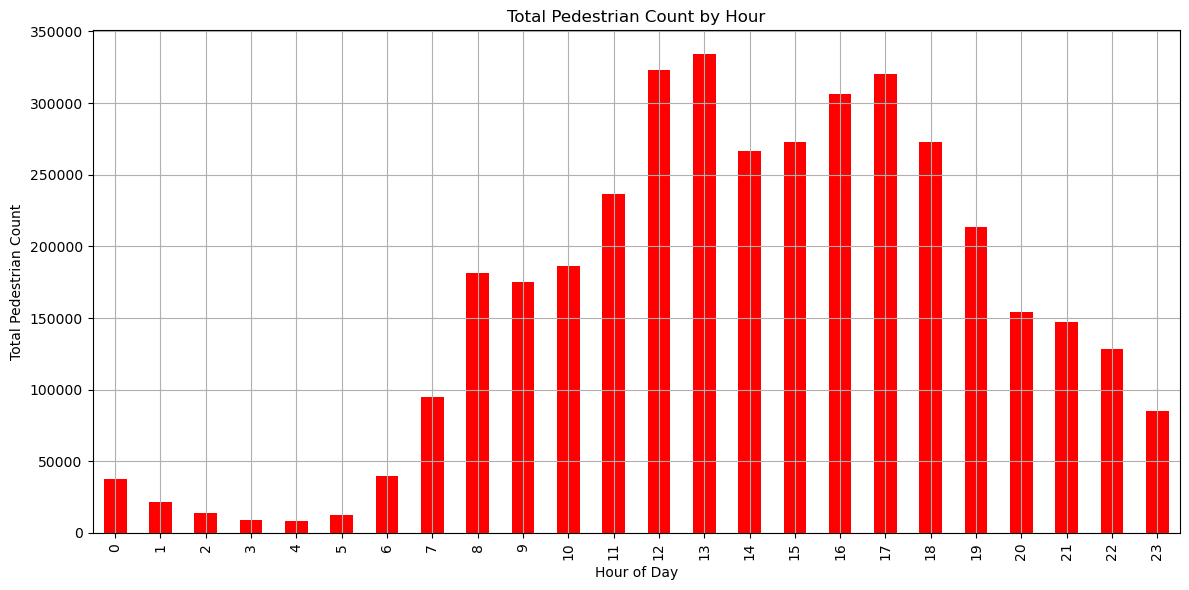

In [57]:
# Group by hour and sum pedestrian counts
hourly_counts = pedestrian_counting.groupby('hourday')['pedestriancount'].sum()

# Plot the grouped data
plt.figure(figsize=(12, 6))
hourly_counts.plot(kind='bar', color='red')

# Add titles and labels
plt.title('Total Pedestrian Count by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Pedestrian Count')
plt.grid(True)
plt.tight_layout()
plt.show()


From the results we can clearly see that the hours of 13 and 17 indicating the two most busiest periods of the day. I beleive this is a good representation of lunch breaks and when work finishes for most individuals. 

## Heatmap of Pedestrian Acitivity(beta)
note: this is just a future plan and may be implemented in the future. 
Goal: to visualise the intensity of pedestrian traffic by hour and day on a heatmap. 

#### Data Quality and Summary Statistics Overview Weather data 
1. **Missing data Check** 
    * I check the total number of missing data within each column with the sue of `.isnull().sum()`, this will indicate if there is missing data and which column does have it. 
2. **Statistical Description** 
    * To obtain a statistical summary I use the `.describe()` method. This will aid in understanding the distribution of the data and will point out any annomailies.
3. **Data Structure Summary** 
    * To obtain a statistical overview of the dataset and find outliers it is useful to implement `.info()`

In [58]:
print("Check for missing information in each column")
print(weather_stations_df .isnull().sum())
print("Statistical Description")
print(weather_stations_df .describe())
print("Data Structure Summary")
print(weather_stations_df .info())

Check for missing information in each column
dev_id                 0
time                   0
rtc                    0
battery                0
solarpanel             0
command                0
solar                  0
precipitation          0
strikes                0
windspeed              0
winddirection          0
gustspeed              0
vapourpressure         0
atmosphericpressure    0
relativehumidity       0
airtemp                0
lat_long               0
sensor_name            0
dtype: int64
Statistical Description
                rtc      battery   solarpanel  command        solar  \
count  9.999000e+03  9999.000000  9999.000000   9999.0  9999.000000   
mean   8.102216e+07     4.180679    10.538702      0.0   112.111911   
std    1.968141e+07     0.025283    10.155104      0.0   196.064160   
min    3.499858e+07     4.128000     0.000000      0.0     0.000000   
25%    6.735316e+07     4.158000     0.217000      0.0     0.000000   
50%    8.118793e+07     4.181000    11.604

1. ***Missing data Check*** 
    * We can see from the results obtained there is no missing data in any column, therefore no need to handle missing values. 

2. ***Statistical Description***
    * Key highlights from statiscal summary: 
    * `precipitiation`:
        - All values are zero this column holds no other value and is a good canditate to be dropped
    * `solar`: 
        - We see a very high max value of 1043 data is strongly skewed, high sunlight levels.  
        - the mean and median values are different
    * `strikes`(lightning): 
        -With a mean value of 0.0048 indicate very few events and a max of 9 indicate low lightnign occurences
    * `windspeed`, `gustspeed`, `winddirection`: 
        - All have extremely large outlier values of -9999.0. this may need to be removed to extract valuable information with similar windspeed and gustspeed averages. 
    * `relativehumidity`: 
        - has a range from 18 to 100 
    * `airtemp`: 
        - has a range from 1deg to 39.2deg celcius indicating normal weather patterns for the city of melbourne.  

3. ***Data Structure Summary*** 
    * We can see the data type of each key feature, providing us with a clear outline of what data we are dealing with. `
    * We see that the time needs to be converted to datetime format for easy time analysis. 
    * lat/lon should also be split to refelct the changes made to the previous dataset to be matched. 

In [59]:
weather_stations_df
# Create a new row named latitude
weather_stations_df['latitude'] = weather_stations_df['lat_long'].apply(lambda x: x['lat'] if isinstance(x, dict) else None)
# Create a new row named longitude
weather_stations_df['longitude'] = weather_stations_df['lat_long'].apply(lambda x: x['lon'] if isinstance(x, dict) else None)

weather_stations_df.head()

,dev_id,time,rtc,battery,solarpanel,command,solar,precipitation,strikes,windspeed,winddirection,gustspeed,vapourpressure,atmosphericpressure,relativehumidity,airtemp,lat_long,sensor_name,latitude,longitude
0,atmos41-32fc,2025-08-02T18:11:13+00:00,120148376,4.146,0.225,0,0,0,0,0.91,176.9,1.47,0.78,101.92,90,4.9,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station,-37.802214,144.965626
1,atmos41-32fc,2025-08-02T19:42:39+00:00,120153862,4.142,0.225,0,0,0,0,0.67,183.6,1.01,0.75,102.00,92,4.0,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station,-37.802214,144.965626
2,atmos41-32fc,2025-08-02T20:12:21+00:00,120155644,4.140,0.233,0,0,0,0,0.82,176.3,1.55,0.74,102.01,92,3.8,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station,-37.802214,144.965626
3,atmos41-32fc,2025-08-02T20:41:52+00:00,120157415,4.139,0.290,0,0,0,0,1.10,183.4,2.07,0.73,102.05,92,3.5,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station,-37.802214,144.965626
4,atmos41-32fc,2025-08-02T23:57:38+00:00,120169161,4.213,22.564,0,114,0,0,1.00,160.6,2.23,0.95,102.06,84,8.7,"{'lon': 144.9656262, 'lat': -37.8022141}",Weather Station,-37.802214,144.965626


In [60]:
#lists out all unique dev_id 
print(weather_stations_df['dev_id'].nunique())
#list all sensor names 
print(weather_stations_df['sensor_name'].nunique()) 
#list all location 
print(weather_stations_df['latitude'].nunique()) 
print(weather_stations_df['longitude'].nunique()) 

1
1
1
1


The results indicate that each of these only have one unique varaible indicating no variance in the data. This means there is only one sensor in one location 
this information indicates that sensor name and dev id are not of value to the AI pedestrain flow prediction. 

### Dropping Unnecessary Columns 
To clean the dataset redundant information is dropped the columns dropped are: 

- **`dev_id`**: A unique identifier for the weather station device however provided there is only one device it will not be necessary and will not contribute any valueable information. 
- **`sensor_name`** Another label for the dev_id this information does not contribute to implementing AI pedestrian flow predictor. 
- **`lat_long`** The location is seperated into longitude and latitude columns and is no longer necessary, also there is only one location utilised. 

In [61]:
weather_stations_df.drop(columns=['dev_id', 'sensor_name', 'lat_long'], inplace=True) 
weather_stations_df.head()

,time,rtc,battery,solarpanel,command,solar,precipitation,strikes,windspeed,winddirection,gustspeed,vapourpressure,atmosphericpressure,relativehumidity,airtemp,latitude,longitude
0,2025-08-02T18:11:13+00:00,120148376,4.146,0.225,0,0,0,0,0.91,176.9,1.47,0.78,101.92,90,4.9,-37.802214,144.965626
1,2025-08-02T19:42:39+00:00,120153862,4.142,0.225,0,0,0,0,0.67,183.6,1.01,0.75,102.00,92,4.0,-37.802214,144.965626
2,2025-08-02T20:12:21+00:00,120155644,4.140,0.233,0,0,0,0,0.82,176.3,1.55,0.74,102.01,92,3.8,-37.802214,144.965626
3,2025-08-02T20:41:52+00:00,120157415,4.139,0.290,0,0,0,0,1.10,183.4,2.07,0.73,102.05,92,3.5,-37.802214,144.965626
4,2025-08-02T23:57:38+00:00,120169161,4.213,22.564,0,114,0,0,1.00,160.6,2.23,0.95,102.06,84,8.7,-37.802214,144.965626


### Visualising weather station df  

A line plot will be utilised to be able to observe air tempreture over time.  

In [ ]:
# Convert 'time' to datetime format
weather_stations_df['time'] = pd.to_datetime(weather_stations_df['time'])

# groupby time 
temperature_time = weather_stations_df.groupby('time')['airtemp']

# Plotting
plt.figure(figsize=(12, 6))
temperature_time.plot(color='blue')

plt.title('Air Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Air Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()